In [1]:
# PyTorch Library
import torch
# PyTorch Neural Network
import torch.nn as nn
# Allows us to transform data
import torchvision.transforms as transforms
# Allows us to download the dataset
import torchvision.datasets as dsets
# Used to graph data and loss curves
import matplotlib.pylab as plt
# Allows us to use arrays to manipulate and store data
import numpy as np

In [2]:
# Define the function for plotting the channels

def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()


# Define the function for plotting the parameters

def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()


# Define the function for plotting the activations

def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.9)    

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()


def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1].item()))

In [3]:
import pandas as pd
df = pd.read_csv("data/chest_xray_train.csv")

In [4]:
df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel4088,pixel4089,pixel4090,pixel4091,pixel4092,pixel4093,pixel4094,pixel4095,file_name,class_id
0,4,3,3,2,1,0,0,0,0,2,...,108,41,0,0,0,0,0,0,img_1002194571005371555.jpg,1
1,0,13,45,71,86,95,109,103,94,96,...,99,33,0,0,0,0,0,0,img_1002972834724824498.jpg,1
2,20,20,20,20,20,20,20,20,20,20,...,53,13,21,20,20,20,20,20,img_1004160693662088646.jpg,0
3,1,11,27,49,83,107,118,123,131,140,...,149,135,112,99,65,32,10,0,img_1011159426506457600.jpg,2
4,47,77,117,79,140,64,55,62,69,67,...,136,117,68,51,36,17,27,36,img_1014387197248837154.jpg,1


In [5]:
import pickle

#Load Static testing and training data
with open('static_data/train.pickle','rb') as handle:
    train_indices = pickle.load(handle)

with open('static_data/test.pickle','rb') as handle:
    test_indices = pickle.load(handle)

# get all pixel columns
selected_features = list(df.columns)
selected_features.remove("file_name")
selected_features.remove("class_id")

# Set train and target
X = df[selected_features]
y = df['class_id']

# Get training and test data
X_train, X_test = X.iloc[train_indices,:], X.iloc[test_indices,:] 
y_train, y_test = y[train_indices], y[test_indices]

In [6]:
train_tensor = torch.tensor(X_train.values, dtype= torch.int16)
test_tensor = torch.tensor(y_test.values, dtype = torch.int16)

In [7]:
for img in train_tensor:
    img = np.reshape(img,(64,64))

In [8]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        # The reason we start with 1 channel is because we have a single black and white image
        # Channel Width after this layer is 16
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        # Channel Wifth after this layer is 8
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        # Channel Width after this layer is 8
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        # Channel Width after this layer is 4
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        # In total we have out_2 (32) channels which are each 4 * 4 in size based on the width calculation above. Channels are squares.
        # The output is a value for each class
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    # Prediction
    def forward(self, x):
        # Puts the X value through each cnn, relu, and pooling layer and it is flattened for input into the fully connected layer
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    # Outputs result of each stage of the CNN, relu, and pooling layers
    def activations(self, x):
        # Outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out

In [9]:
# Create the model object using CNN class

model = CNN(out_1=16, out_2=32)

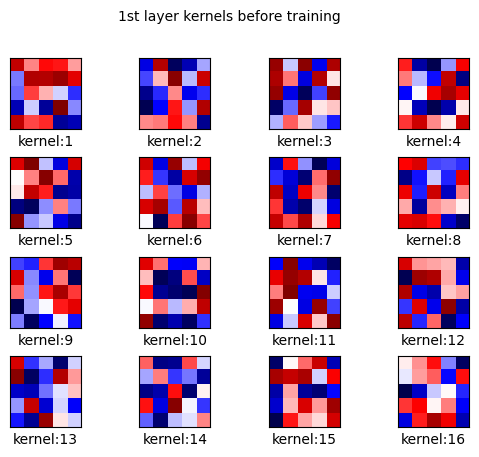

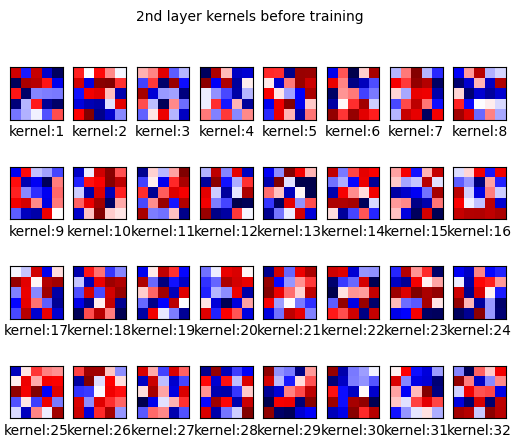

In [10]:
# Plot the parameters

plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

In [14]:
# We create a criterion which will measure loss
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
# Create an optimizer that updates model parameters using the learning rate and gradient
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
# Create a Data Loader for the training data with a batch size of 100 
train_loader = torch.utils.data.DataLoader(dataset=X_train)
# Create a Data Loader for the validation data with a batch size of 5000 
validation_loader = torch.utils.data.DataLoader(dataset=y_test)

In [15]:
train_loader

In [13]:
# Train the model

# Number of times we want to train on the taining dataset
n_epochs=3
# List to keep track of cost and accuracy
cost_list=[]
accuracy_list=[]
# Size of the validation dataset
N_test=len(y_test)

# Model Training Function
def train_model(n_epochs):
    # Loops for each epoch
    for epoch in range(n_epochs):
        # Keeps track of cost for each epoch
        COST=0
        # For each batch in train loader
        for x, y in train_loader:
            # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
            optimizer.zero_grad()
            # Makes a prediction based on X value
            z = model(x)
            # Measures the loss between prediction and acutal Y value
            loss = criterion(z, y)
            # Calculates the gradient value with respect to each weight and bias
            loss.backward()
            # Updates the weight and bias according to calculated gradient value
            optimizer.step()
            # Cumulates loss 
            COST+=loss.data
        
        # Saves cost of training data of epoch
        cost_list.append(COST)
        # Keeps track of correct predictions
        correct=0
        # Perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            # Makes a prediction
            z = model(x_test)
            # The class with the max value is the one we are predicting
            _, yhat = torch.max(z.data, 1)
            # Checks if the prediction matches the actual value
            correct += (yhat == y_test).sum().item()
        
        # Calcualtes accuracy and saves it
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
train_model(n_epochs)

KeyError: 0

In [ ]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Define relevant variables for the ML task
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 20

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
